In [68]:
inpath = 'tablellama/output_temperature_0.1/'

In [ ]:
# for folder in $(ls -d tablellama/*/); do papermill temperature-preprocess.ipynb -p inpath $folder tmp.json; don

In [71]:
prefix, folder = inpath.split('/')[:2]

In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pandas as pd
import seaborn as sns
import pickle
import math
from IPython.display import clear_output
import numpy as np
import re
import os

sns.set_context("notebook", font_scale=1.25)
 
file_path = "turl_test_2k_prompts_50_unique.jsonl"
device = torch.device("mps")

In [2]:
# https://github.com/ipython-contrib/jupyter_contrib_nbextensions/pull/1663

In [14]:
from io import BytesIO

def fix(map_loc):
    # Closure rather than a lambda to preserve map_loc 
    return lambda b: torch.load(BytesIO(b), map_location=map_loc)

class MappedUnpickler(pickle.Unpickler):
    # https://github.com/pytorch/pytorch/issues/16797#issuecomment-633423219

    def __init__(self, *args, map_location='cpu', **kwargs):
        self._map_location = map_location
        super().__init__(*args, **kwargs)

    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return fix(self._map_location)
        else: 
            return super().find_class(module, name)

def mapped_loads(s, map_location='cpu'):
    bs = BytesIO(s)
    unpickler = MappedUnpickler(bs, map_location=map_location)
    return unpickler.load()

In [3]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [5]:
# load questions (to be removed)

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [6]:
os.path.join(prefix, folder)

'tablellama/output_temperature_0.1'

In [22]:
import os
import pickle
from copy import copy, deepcopy

pre_keys = ['pre_output_proba_topn',
 'pre_output_proba_topk',
 'pre_output_true_entropies',
 'pre_output_layers_kl']

run = 0
outlist = []

for pid, single_file in enumerate(os.listdir(os.path.join(prefix, folder))):
    if single_file.startswith('_') or single_file.startswith('.'): continue
    with open(os.path.join(prefix, folder, single_file), 'rb') as handle:        
        item = mapped_loads(handle.read())
        for i, _ in enumerate(item["post_output_sequences"]):
                
            item_ = copy(item)
            item_["post_output_sequences"] = item["post_output_sequences"][i]
                
            item_["transition_scores_s"] = item["transition_scores_s"][i]
            item_["transition_scores_l"] = item["transition_scores_l"][i]

            item_["run"] = run + i
                
            outlist.append(item_)
    

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_91881/3807410893.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(BytesIO(b), map_l

In [23]:
# prefix, model_name = './tablellama-complete/', "osunlp/TableLlama"
# prefix, model_name = './gemma-9b-complete/', "google/gemma-2-9b-it"

model_name = item['args']['model_name'] # get model from last processed item
print(model_name)

if model_name.startswith("osunlp"):
    config = transformers.AutoConfig.from_pretrained(model_name)

    orig_ctx_len = getattr(config, "max_position_embeddings", None)
    context_size = 8192
    if orig_ctx_len and context_size > orig_ctx_len:
            scaling_factor = float(math.ceil(context_size / orig_ctx_len))
            config.rope_scaling = {"type": "linear", "factor": scaling_factor}

    tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                              model_max_length=(context_size if context_size > orig_ctx_len else orig_ctx_len),
                                              padding_side="left", 
                                              use_fast=False)

else:
    config = transformers.AutoConfig.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

osunlp/TableLlama


### check output against ground truth

In [24]:
%%time

# show results

c=0
t=0
h=0

truth = []
outseq = []

pdbg = None

for idx, p in enumerate(outlist):
    
    if idx%100==0: 
        clear_output(wait=True)
        print(idx, end='\r')
    c+=1
    pdbg = p
    
    # in
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
        
    # computed
    # post_output_scores = p['post_output_scores']
    post_output_sequences = p['post_output_sequences']
    
    # bases
    baseid = len(inputs["input_ids"][0]) + 1
    endid = len(post_output_sequences[0])
    # lookout
    generated_ids = post_output_sequences
    generated_text = tokenizer.decode(generated_ids[0][baseid:endid], skip_special_tokens=True)
    # print
    # print(generated_text)
    # print(p['output'])
    # print('\n')
    #test
    
    # replacement due to tablellama "hallucinations"
    a = generated_text.replace('[DESCRIPTION]', '[DESC]').lower().strip()
    a = " ".join(a.split(" "))
    if len(a) < 1: 
        print("SOMETHING WENT HORRIBLY WRONG, GIVING UP")
        break

    b = p['output'].lower().strip()
    b = " ".join(b.split(" "))
    # correct
    correct = False
    hallucinated = False
    if ((a in b) or (b in a) or (b.startswith(a)) or (a.startswith(b))) and (('desc' in a) and ('type' in a)): 
        correct = True
        t+=1
    # hallucinated
    elif a not in prompt.lower().strip(): 
        h+=1
        hallucinated = True
    # incorrect
    else:
        pass
        #print(generated_text)
        #print(p['output'])
        #print('\n')
        # print(prompt)
        # print('\n')
        
    # loose correctness
    _, three_ = b.split('[type]')
    one_, two_ = _.split('[desc]')
    one_ = one_.replace('<', '').replace('>', '').replace(']', '').replace('[', '').strip()
    two_ = two_.replace('<', '').replace('>', '').replace(']', '').replace('[', '').strip()
    three_ = three_.replace('<', '').replace('>', '').replace(']', '').replace('[', '').strip()
    
    loosely_correct = False
    matched_string = None
    try:                  
        regex = re.compile(r'^.{0,2}(' + re.escape(one_) + r'.{0,8}' + re.escape(two_) + r'.{0,8}' + re.escape(three_) + r')')
        match = regex.search(a)
        if match: 
            loosely_correct = True
            matched_string = match.group(1)
    except Exception as e:
        pass# if it fails, default

    truth.append((p['run'], p['pid'], correct, hallucinated, loosely_correct))
    outseq.append((p['run'], p['pid'], a, post_output_sequences, b, matched_string))


CPU times: user 13.6 s, sys: 604 ms, total: 14.2 s
Wall time: 16 s


In [25]:
len(inputs.input_ids[0]), len(post_output_sequences[0])

(3858, 3878)

In [26]:
# true, hallucinated, counted
# (3702, 26, 5120) tablellama old
# (11190, 880, 14770) gemma 9b
t, h, c

(1727, 0, 2080)

In [27]:
# correct answers rate, hallucinated answers rate
t/c, h/c

(0.8302884615384616, 0.0)

In [28]:
truth = pd.DataFrame(truth, columns=['run', 'pid', 'correct', 'hallucinated', 'loosely_correct'])

In [29]:
corec = truth.groupby('pid').correct.mean()

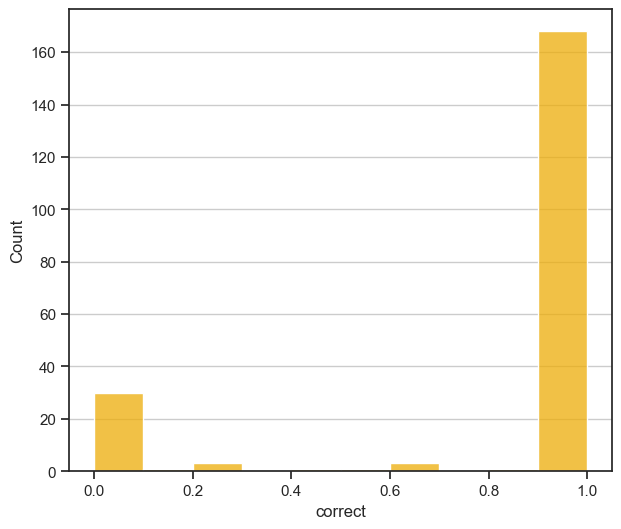

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(corec, bins=corec.nunique(), color=Prism_10.mpl_colors[5])

ax.yaxis.grid(True)

plt.show()

In [31]:
# probability mass for "convinced" prediction
(np.isclose(corec, 0.) | np.isclose(corec, 1.)).sum() / corec.shape[0]

0.9471153846153846

In [32]:
# how many "changed at least once"
((corec>0.) & (corec<1.)).sum() / corec.shape[0]

0.052884615384615384

In [33]:
# again but without hallucinated

truth_ = truth[(~truth.hallucinated)].copy()
truth_['true_err'] = truth_.correct

corec_ = truth_.groupby('pid').true_err.mean()

((corec_>0.) & (corec_<1.)).sum() / corec_.shape[0]

0.052884615384615384

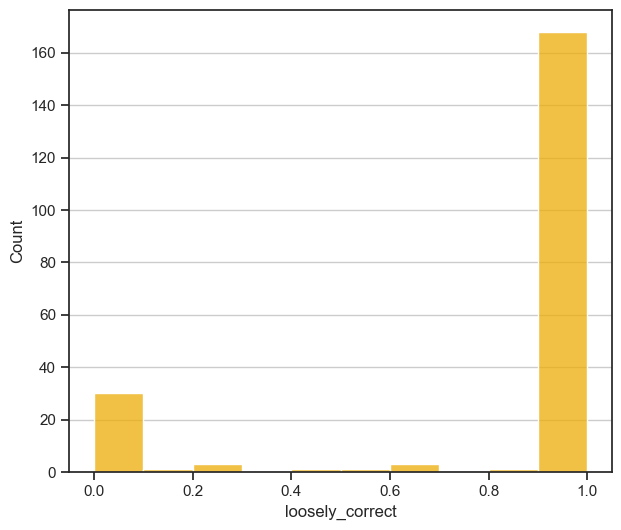

In [34]:
# loosely correct

import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

corek = truth.groupby('pid').loosely_correct.mean()

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(corek, bins=corek.nunique(), color=Prism_10.mpl_colors[5])

ax.yaxis.grid(True)

plt.show()

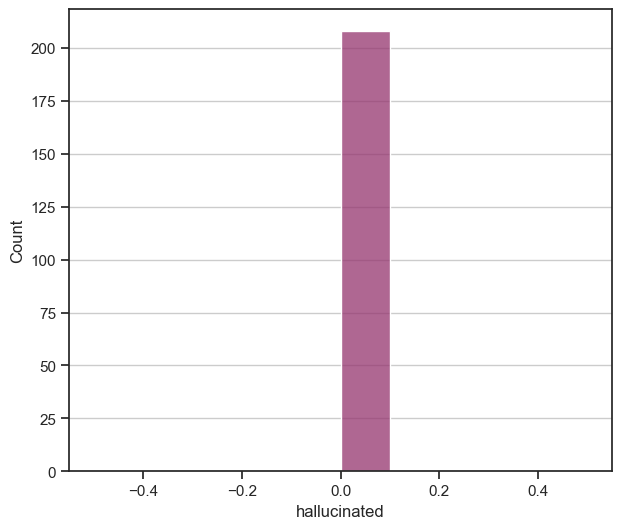

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(truth.groupby('pid').hallucinated.mean(), bins=corec.nunique(), color=Prism_10.mpl_colors[8])

ax.yaxis.grid(True)

plt.show()

In [36]:
# how many hallucinated
(truth.groupby('pid').hallucinated.mean()>0.).sum() / truth.pid.nunique()

0.0

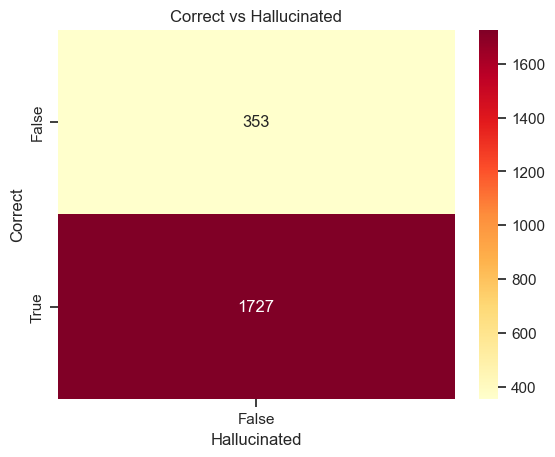

In [37]:
contingency = pd.crosstab(truth.correct, truth.hallucinated)

sns.heatmap(contingency, annot=True, fmt="d", cmap="YlOrRd")

plt.title("Correct vs Hallucinated")
plt.xlabel("Hallucinated")
plt.ylabel("Correct")
plt.show()

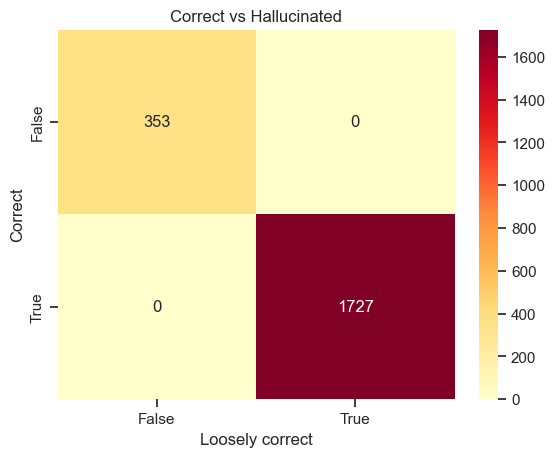

In [38]:
contingency = pd.crosstab(truth.correct, truth.loosely_correct)

sns.heatmap(contingency, annot=True, fmt="d", cmap="YlOrRd")

plt.title("Correct vs Hallucinated")
plt.xlabel("Loosely correct")
plt.ylabel("Correct")
plt.show()

In [40]:
# answers
answers = pd.DataFrame(outseq, columns=['run', 'pid', 'answer', 'answer_seq', 'right_answer', 'regex_match'])
answers.answer = answers.answer.str[:-1]

In [41]:
# min and max number of unique answers
answers.groupby('pid').answer.nunique().min(), answers.groupby('pid').answer.nunique().max()

(1, 2)

In [42]:
answers

,run,pid,answer,answer_seq,right_answer,regex_match
0,0,872,ifuleave [desc] 2008 single by musiq soulchild...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<ifuleave [desc] 2008 single by musiq soulchil...,ifuleave [desc] 2008 single by musiq soulchild...
1,1,872,ifuleave [desc] 2008 single by musiq soulchild...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<ifuleave [desc] 2008 single by musiq soulchil...,ifuleave [desc] 2008 single by musiq soulchild...
2,2,872,ifuleave [desc] 2008 single by musiq soulchild...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<ifuleave [desc] 2008 single by musiq soulchil...,ifuleave [desc] 2008 single by musiq soulchild...
3,3,872,ifuleave [desc] 2008 single by musiq soulchild...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<ifuleave [desc] 2008 single by musiq soulchil...,ifuleave [desc] 2008 single by musiq soulchild...
4,4,872,ifuleave [desc] 2008 single by musiq soulchild...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<ifuleave [desc] 2008 single by musiq soulchil...,ifuleave [desc] 2008 single by musiq soulchild...
...,...,...,...,...,...,...
2075,5,1579,major general [desc] military rank of the unit...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<major general [desc] military rank [type] mil...,None
2076,6,1579,major general [desc] military rank of the unit...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<major general [desc] military rank [type] mil...,None
2077,7,1579,major general [desc] military rank of the unit...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<major general [desc] military rank [type] mil...,None
2078,8,1579,major general [desc] military rank of the unit...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<major general [desc] military rank [type] mil...,None


In [43]:
# wrong answers

import numpy as np
def fun (a,b):
    return a.startswith(b) or b.startswith(a)

foon = np.vectorize(fun)
aoh = pd.Series(foon(answers.answer, answers.right_answer), index=answers.index)

answers[~aoh]

,run,pid,answer,answer_seq,right_answer,regex_match
0,0,872,ifuleave [desc] 2008 single by musiq soulchild...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<ifuleave [desc] 2008 single by musiq soulchil...,ifuleave [desc] 2008 single by musiq soulchild...
1,1,872,ifuleave [desc] 2008 single by musiq soulchild...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<ifuleave [desc] 2008 single by musiq soulchil...,ifuleave [desc] 2008 single by musiq soulchild...
2,2,872,ifuleave [desc] 2008 single by musiq soulchild...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<ifuleave [desc] 2008 single by musiq soulchil...,ifuleave [desc] 2008 single by musiq soulchild...
3,3,872,ifuleave [desc] 2008 single by musiq soulchild...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<ifuleave [desc] 2008 single by musiq soulchil...,ifuleave [desc] 2008 single by musiq soulchild...
4,4,872,ifuleave [desc] 2008 single by musiq soulchild...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<ifuleave [desc] 2008 single by musiq soulchil...,ifuleave [desc] 2008 single by musiq soulchild...
...,...,...,...,...,...,...
2075,5,1579,major general [desc] military rank of the unit...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<major general [desc] military rank [type] mil...,None
2076,6,1579,major general [desc] military rank of the unit...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<major general [desc] military rank [type] mil...,None
2077,7,1579,major general [desc] military rank of the unit...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<major general [desc] military rank [type] mil...,None
2078,8,1579,major general [desc] military rank of the unit...,"[[1, 13866, 338, 385, 15278, 393, 16612, 263, ...",<major general [desc] military rank [type] mil...,None


In [44]:
pd.set_option('max_colwidth', 200)

In [45]:
# correct but not loosely correct?
gg = pd.merge(truth, answers, on=['run', 'pid'], how='inner')
gg[(~gg.loosely_correct) & (gg.correct)]

,run,pid,correct,hallucinated,loosely_correct,answer,answer_seq,right_answer,regex_match


In [46]:
# only loosely correct
gg = pd.merge(truth, answers, on=['run', 'pid'], how='inner')
gg[(gg.loosely_correct) & (~gg.correct)].drop_duplicates(subset='pid')

,run,pid,correct,hallucinated,loosely_correct,answer,answer_seq,right_answer,regex_match


### sequence components alignment
### (build "segments" for each sequence)

In [47]:
def is_sublist(c, m, label):
    if not c: return False
    if not m or len(c) > len(m): return False

    for i in range(len(m) - len(c) + 1):
        if m[i:i+len(c)] == c:
            return (i, i + len(c), label)
    return False

In [48]:
# %%time

checks = []
alls = set()

for idx, p in enumerate(outlist):
    if idx%100==0: 
        clear_output(wait=True)
        print(idx, end='\r')
    
    run = p['run']
    pid = p['pid']
    
    alls.add(p['table'])
    
    # this is the generated sequence
    output_seq = p['post_output_sequences'][0]
    
    # overall prompt sequence
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    prompt_seq = tokenizer(prompt, return_tensors="pt")
    prompt_seq = prompt_seq['input_ids'][0].numpy().tolist()

    # subsequences
    instruction_seq = tokenizer(p["instruction"], return_tensors="pt")
    instruction_seq = instruction_seq['input_ids'][0].numpy().tolist()

    question_seq = tokenizer(p["question"], return_tensors="pt")
    question_seq = question_seq['input_ids'][0].numpy().tolist()

    input_seq = tokenizer(p["input"], return_tensors="pt")
    input_seq = input_seq['input_ids'][0].numpy().tolist()

    postilla = " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    postilla += "\n\n### Response:"
    postilla_seq = tokenizer(postilla, return_tensors="pt")
    postilla_seq = postilla_seq['input_ids'][0].numpy().tolist()
    
    # subseq matching
    if model_name.startswith('osunlp'): start_tok = 2
    else: start_tok = 1
    
    instruction_match = is_sublist(instruction_seq[start_tok:], output_seq, 'instruction')
    if not instruction_match: instruction_match = is_sublist(instruction_seq[start_tok:-1], output_seq, 'instruction')
    input_match = is_sublist(input_seq[start_tok:], output_seq, 'input')
    if not input_match: input_match = is_sublist(input_seq[start_tok:-1], output_seq, 'input')
    question_match = is_sublist(question_seq[start_tok:], output_seq, 'question')
    if not question_match: question_match = is_sublist(question_seq[start_tok:-1], output_seq, 'question')
    postilla_match = is_sublist(postilla_seq[start_tok:], output_seq, 'postilla')
    
    # boundaries are inclusive
    checks.append((run, pid, 0, instruction_match[0] - 1, 'preamble')) # preamble
    checks.append((run, pid, instruction_match[0]) + instruction_match[1:])
    checks.append((run, pid, instruction_match[1] + 1) + input_match[1:]) # sew to preceding
    # checks.append((run, pid, input_match[1] + 1) + question_match[1:]) # sew to preceding
    checks.append((run, pid, input_match[1] + 1) + (postilla_match[0]-1, 'question')) # sew to both   
    
    # CORRECT skipped the last token in pre_
    checks.append((run, pid, postilla_match[0], len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    checks.append((run, pid, len(prompt_seq) , len(output_seq) - 1, 'generated')) # assume everything else is generated    
    
    # COMPATIBILITY with crippled cache
    # checks.append((run, pid, postilla_match[0], len(prompt_seq) - 2, 'postilla'))
    # checks.append((run, pid, len(prompt_seq)-1 , len(output_seq) - 2, 'generated')) # assume everything else is generated    
    
    
    # before caching dirty trick
    # checks.append((run, pid, postilla_match[0] + 1, len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    # checks.append((run, pid, len(prompt_seq), len(output_seq) - 1, 'generated')) # assume everything else is generated
    
    #print(len(prompt_seq), len(output_seq) - 1)


In [49]:
# check the checks (must be False)
'False' in checks

False

In [50]:
segments = pd.DataFrame(checks, columns = ['run', 'pid', 'start', 'end', 'segment'])

In [51]:
segments['seq'] = segments.segment.map({'preamble': 0, 'instruction': 1, 'input': 2, 'question': 3, 'postilla': 4, 'generated': 5})

In [52]:
segments['length'] = segments.end - segments.start + 1

In [53]:
segments

,run,pid,start,end,segment,seq,length
0,0,872,0,39,preamble,0,40
1,0,872,40,135,instruction,1,96
2,0,872,136,529,input,2,394
3,0,872,530,1863,question,3,1334
4,0,872,1864,1929,postilla,4,66
...,...,...,...,...,...,...,...
12475,9,1579,40,135,instruction,1,96
12476,9,1579,136,2450,input,2,2315
12477,9,1579,2451,3791,question,3,1341
12478,9,1579,3792,3857,postilla,4,66


### segment description

In [54]:
avg_seq_widths = segments.groupby(['segment', 'seq']).length.agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('seq')
avg_seq_widths = avg_seq_widths.rename(columns = {'mean': 'avg_length', 
                                                  'std': 'std_length', 
                                                  'min': 'min_length',
                                                  'max': 'max_length'})
avg_seq_widths['avg_length_rel'] = avg_seq_widths['avg_length'] / avg_seq_widths['avg_length'].sum()
avg_seq_widths['avg_cumlen'] = avg_seq_widths['avg_length_rel'].cumsum() 
avg_seq_widths

,segment,seq,avg_length,std_length,min_length,max_length,avg_length_rel,avg_cumlen
4,preamble,0,40.000000,0.000000,40,40,0.016142,0.016142
2,instruction,1,96.000000,0.000000,96,96,0.038742,0.054884
1,input,2,952.259615,607.665480,167,2646,0.384293,0.439177
5,question,3,1298.269231,271.326201,310,2438,0.523928,0.963104
3,postilla,4,66.000000,0.000000,66,66,0.026635,0.989739
0,generated,5,25.425962,5.266199,17,46,0.010261,1.000000


<Axes: xlabel='length', ylabel='Count'>

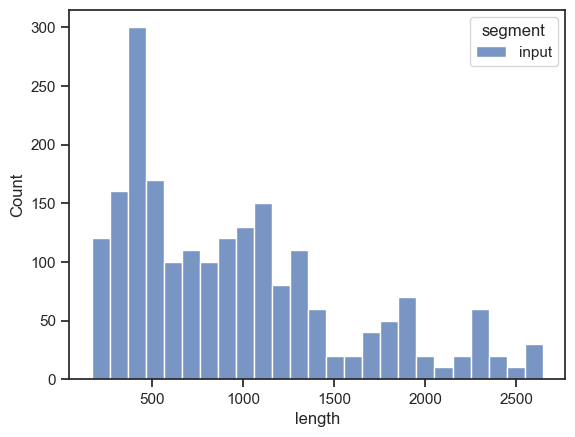

In [55]:
sns.histplot(segments[segments.segment=='input'], x='length', hue='segment', multiple='dodge', binwidth=100)

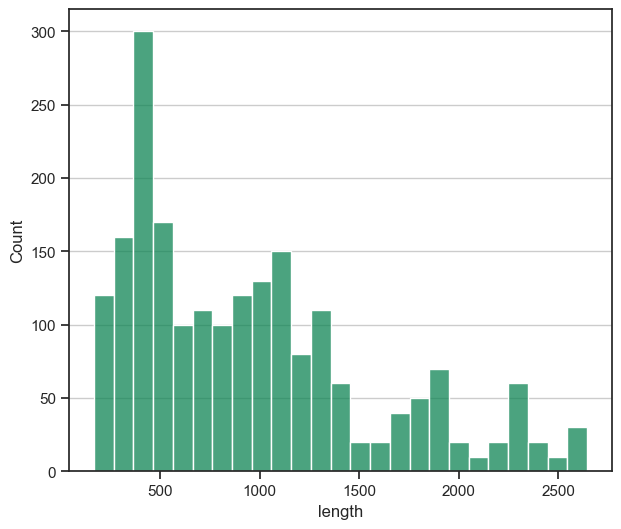

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))

sns.histplot(segments[segments.segment=='input'], x='length', color=Prism_10.mpl_colors[3], multiple='dodge', binwidth=100)

ax.yaxis.grid(True)

plt.show()

In [57]:
# Define background regions [(start, end, color, label)] based on the cumulative sections spans (for the first viz above)

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

myl = avg_seq_widths.avg_cumlen.to_list()
sections = ['preamble', 'instruction', 'input', 'question', 'postilla', 'generated']


first = (0., myl[0], palette[0], sections[0])
background_regions = [first]

for z1, z2, l, i in zip(myl, myl[1:], sections[1:], range(len(myl))):
    background_regions.append((z1,z2, palette[i+1], l))

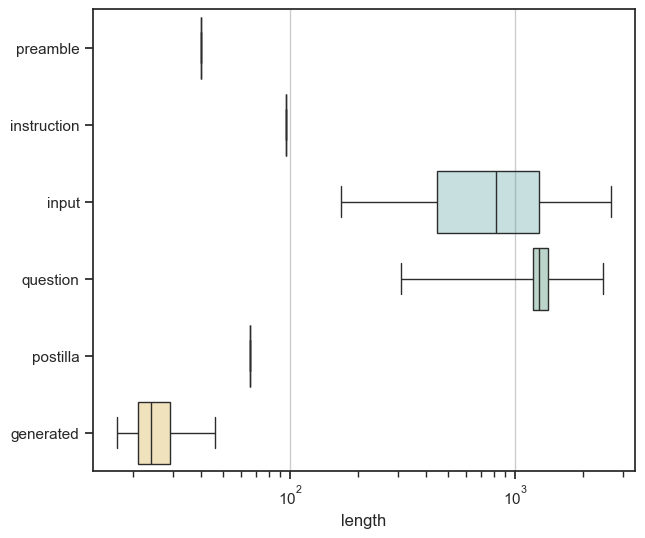

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Plot the orbital period with horizontal boxes
sns.boxplot(
    segments, x="length", y="segment", hue="segment",
    whis=[0, 100], palette=[b[2] for b in background_regions]
)

for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

ax.xaxis.grid(True)
ax.set(ylabel="")

plt.show()

In [65]:
myoutdict = {'truth': truth, 'segments': segments, 'answers': answers, 'model_name': model_name}

import pickle

with open(prefix + '/preprocessed.' + folder + '.pickle', 'wb') as handle:
    pickle.dump(myoutdict, handle, protocol=pickle.HIGHEST_PROTOCOL)
